# 1. Lazy Evaluation
The main idea behind lazy evaluation is to evaluation expressions only when needed. Unlike eager evaluation, lazily evaluated objects do not return the computed results immediately. However, lazily evaluated operations return a **thunk** object. You can think of this as an object that contains the computation of the statements/expressions. Examples of lazy evaluation in python include iterators, generators, and closures. 

We can take a look at pythons generator to get a better idea of how lazy evaluation works. We can start with a basic python function that is eagerly evaluated:

In [2]:
def my_func(a, b):
    return a * b + 3

result = my_func(10, 20)
result

203

We can utilize a python generator in order to utilize lazy evaluation:

In [3]:
def my_lazy_func(a, b):
    a = a + 2
    b = b * 10
    yield a, b

In [4]:
lazy_result = my_lazy_func(5, 8)
lazy_result

<generator object my_lazy_func at 0x111563a40>

We see that the return of the generator is a generator object, that has not been evaluated yet. In order evaluate and get the result we must call the `next` function:

In [5]:
next(lazy_result)

(7, 80)

This allows us to only evaluate expressions when we need them! This is very powerful since it allows for intelligent scheduling and algorithms to be utilized to prevent a simple serial executions. This means we can ensure that expressions are evaluated when we want them to be, saving on memory and computation!

# 2. `dask.delayed`
`dask.delayed` wraps our existing python code and signals dask to make it parallel if possible. It returns a lazy delayed object. If we have a python function and wrap it inside dask delayed, we will get a lazy delayed object that is lazily evaluated. The computations inside that function are broken down into simple tasks, which are connected via a task graph. 

Let's go through an example to make this more concrete:

In [16]:
def do_something_1(x, y):
    return x + y + 2*x*y


def do_something_2(a, b):
    return a**3 - b**3


def do_something_3(p, q):
    return p*p + q*q

In [42]:
x = [2, 4, 6, 8, 10]
y = [3, 6, 9, 12, 15]
z = [10, 20, 30, 40, 50]

final_result = []

In [18]:
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)

In [19]:
final_result

[947018, 60594020, 690180570, 3877846928, 14792746250]

In [20]:
sum(final_result)

19422314786

In pure python the `for` loop above is a serial execution. What this means is that once each iteration has been evaluated, only then will the subsequent iteration start executing. In other words, if the for loop is currently on the iteration where `i = 0`, then the iteration where `i = 1` cannot start. Clearly this can be parallelized! Let's give this a shot with `dask.delayed`:

In [21]:
from dask import delayed, compute

In [26]:
for i in range(0, len(x)):
    # Wrap the function calls inside delayed
    res_1 = delayed(do_something_1)(x[i], y[i])
    res_2 = delayed(do_something_2)(y[i], z[i])
    res_3 = delayed(do_something_3)(res_1, res_2)
    
    final_result.append(res_3)
    
final_sum = delayed(sum)(final_result)

We can see this is lazily evaluated: 

In [27]:
final_sum

Delayed('sum-752a2345-e5ae-4869-b6d4-abc8d9752383')

To evaluated we must call `compute`:

In [28]:
final_sum.compute()

19422314786

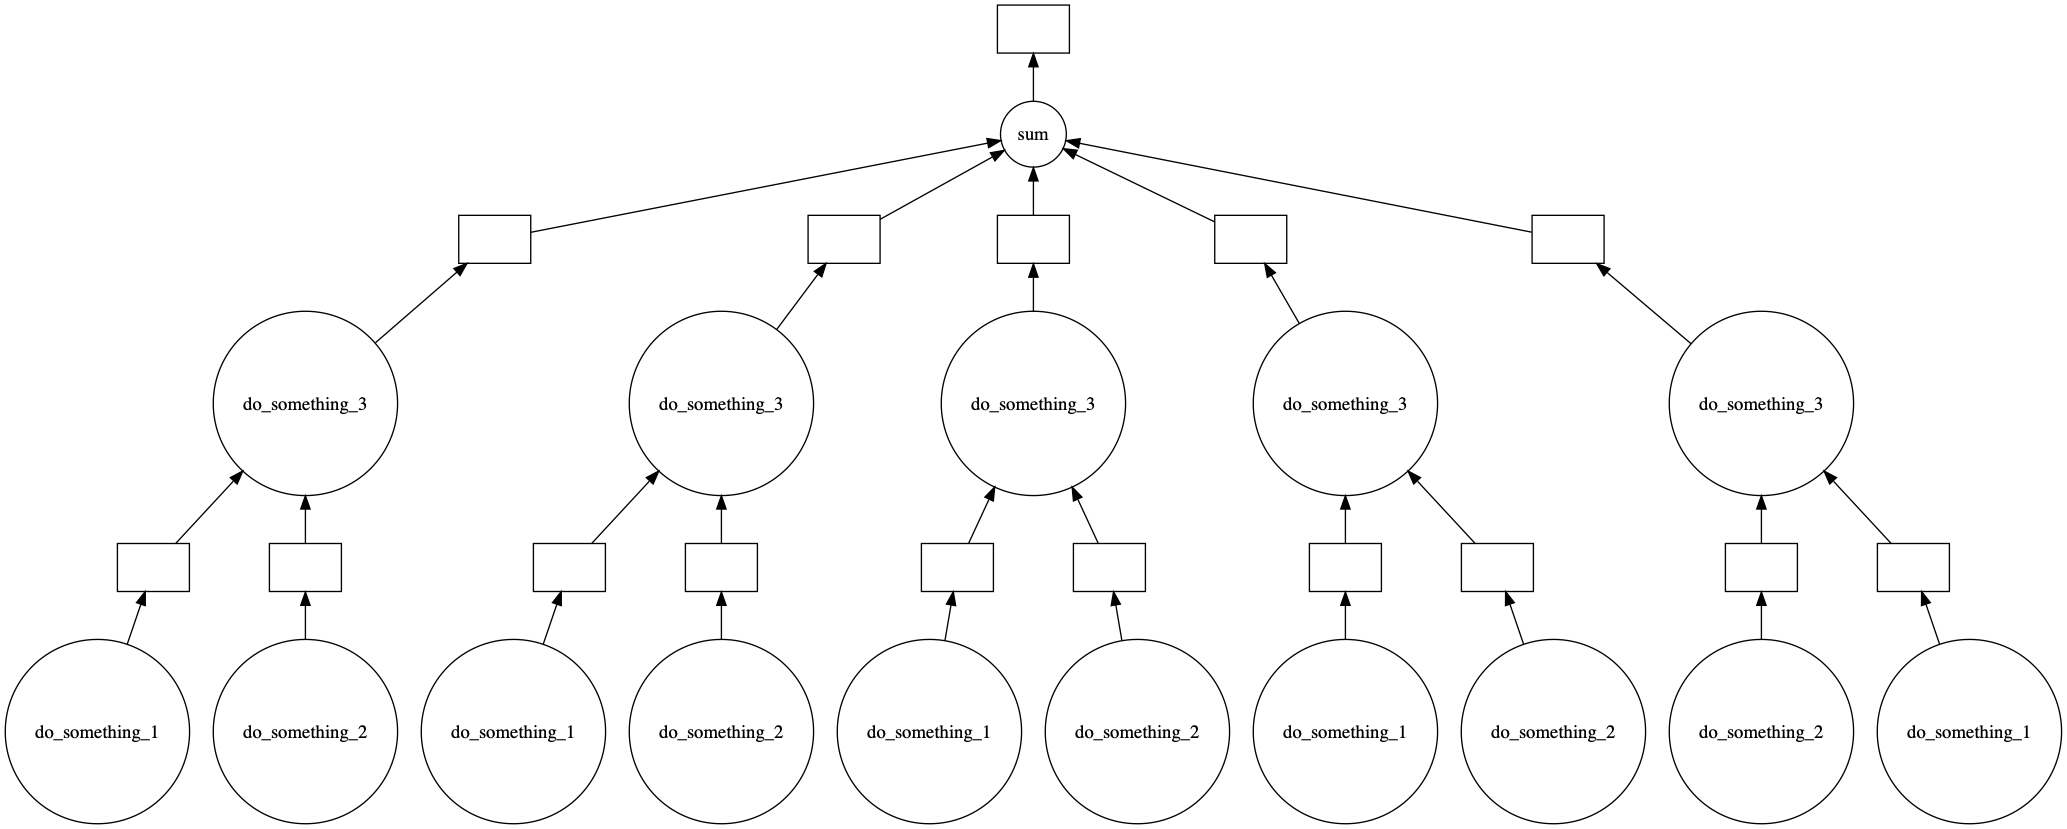

In [29]:
final_sum.visualize()

We can see that for each indexed element of `x`, `y`, and `z` our tasks are done in parallel (each list has 4 elements, which is where there are 4 different parallel tasks.

Another way of using delayed is by using the `@delayed` decorator:

In [38]:
@delayed
def do_something_1(x, y):
    return x + y + 2*x*y


@delayed
def do_something_2(a, b):
    return a**3 - b**3


@delayed
def do_something_3(p, q):
    return p*p + q*q

In [32]:
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)

In [35]:
final_result

[Delayed('do_something_3-5c1e873d-5a58-4475-b1c7-28e5cc2e2549'),
 Delayed('do_something_3-b9da78e2-cefa-444c-9a30-6c25eb3d1224'),
 Delayed('do_something_3-404709f7-10f6-4adf-9b14-e3976e428add'),
 Delayed('do_something_3-577939b9-3e8e-418f-870d-82488b34a7da'),
 Delayed('do_something_3-e2b87f29-cbed-43c6-a641-8f5e4677b8dd')]

In [36]:
final_sum = delayed(sum)(final_result)
final_sum.compute()

19422314786

# 3. Task Graphs
When `dask.delayed` wraps a function, the underlying computation is broken down into a set of tasks. These dasks are connected together via directed edges (depending upon the sequence of tasks). Dask will try to to connect these sets in a parallel way if possible. 

The resultant DAG (directed acyclic graph) is known as a **task graph**. 



In [43]:
for i in range(0, 3):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)
    
final_sum = delayed(sum)(final_result)
final_sum.compute()

751721608

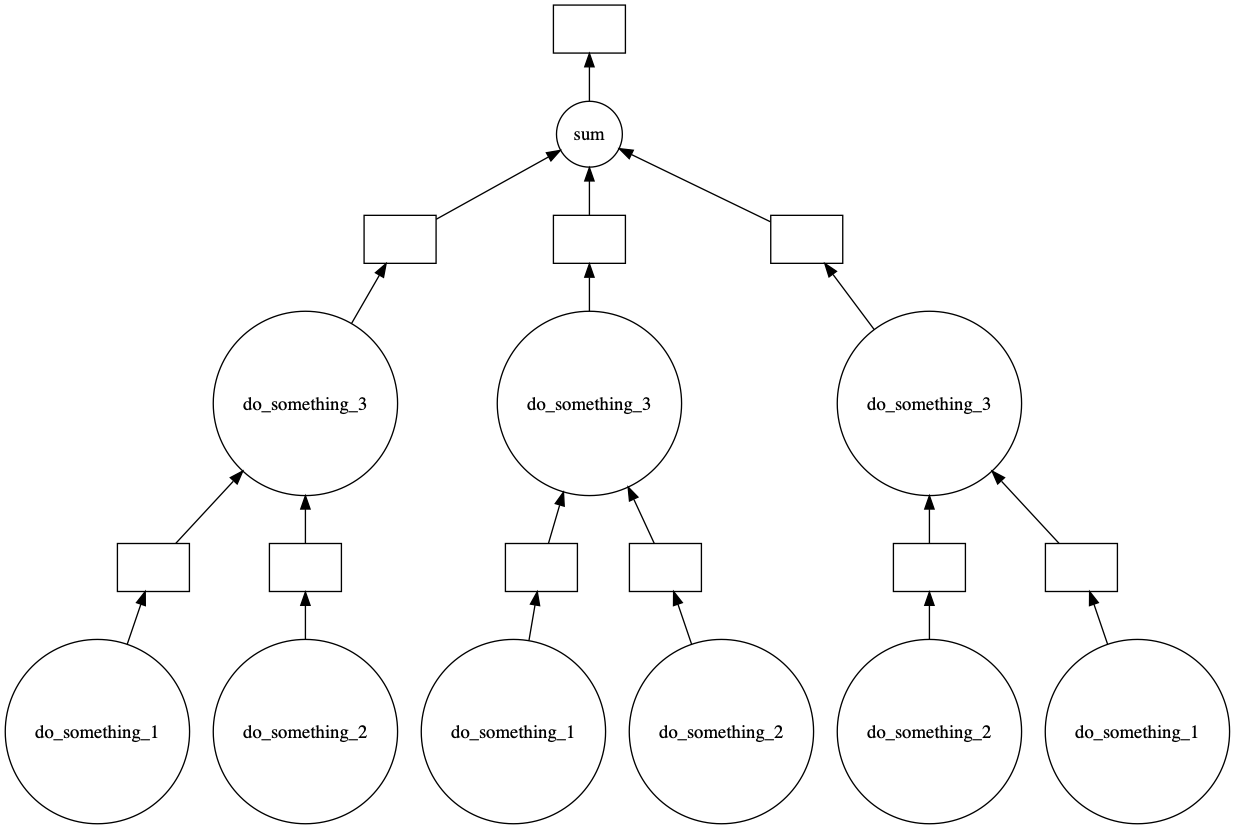

In [44]:
final_sum.visualize()

Above we see the task graph for the previous code block. Let's look at another example:

Chunks are: ((3, 3, 3, 3, 3),)


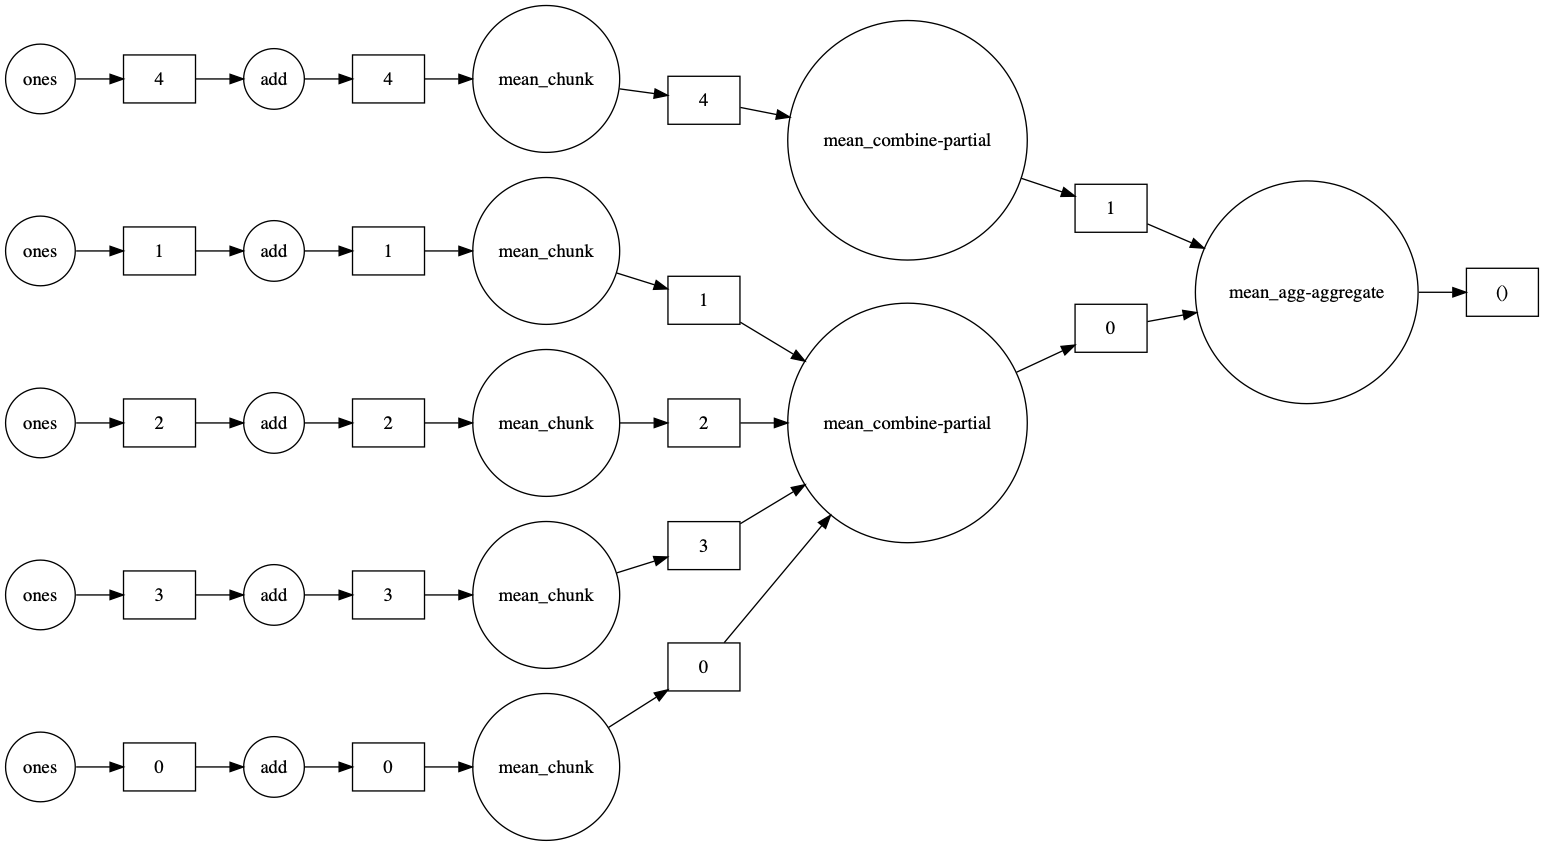

In [49]:
import dask.array as da
arr_1 = da.ones(15, chunks=3) # chunks specifies chunk size
arr_2 = da.ones(15, chunks=3)

print(f"Chunks are: {arr_1.chunks}")

sum_arr = da.add(arr_1, arr_2)
mean_arr = da.mean(sum_arr)

mean_arr.visualize(rankdir="LR")

Above, we have 15 elements and a chunk size of 3, meaning we have 5 chunks of 3 elements each. Each individual chunk of `arr_1` is added to the respective chunk of `arr_2` (see there are 5 specific operation path's starting on the left). The mean of these added chunks is then taken and partially combined, and then finally aggregated in `mean_agg-aggregate`. 

We can look at another more complex example:

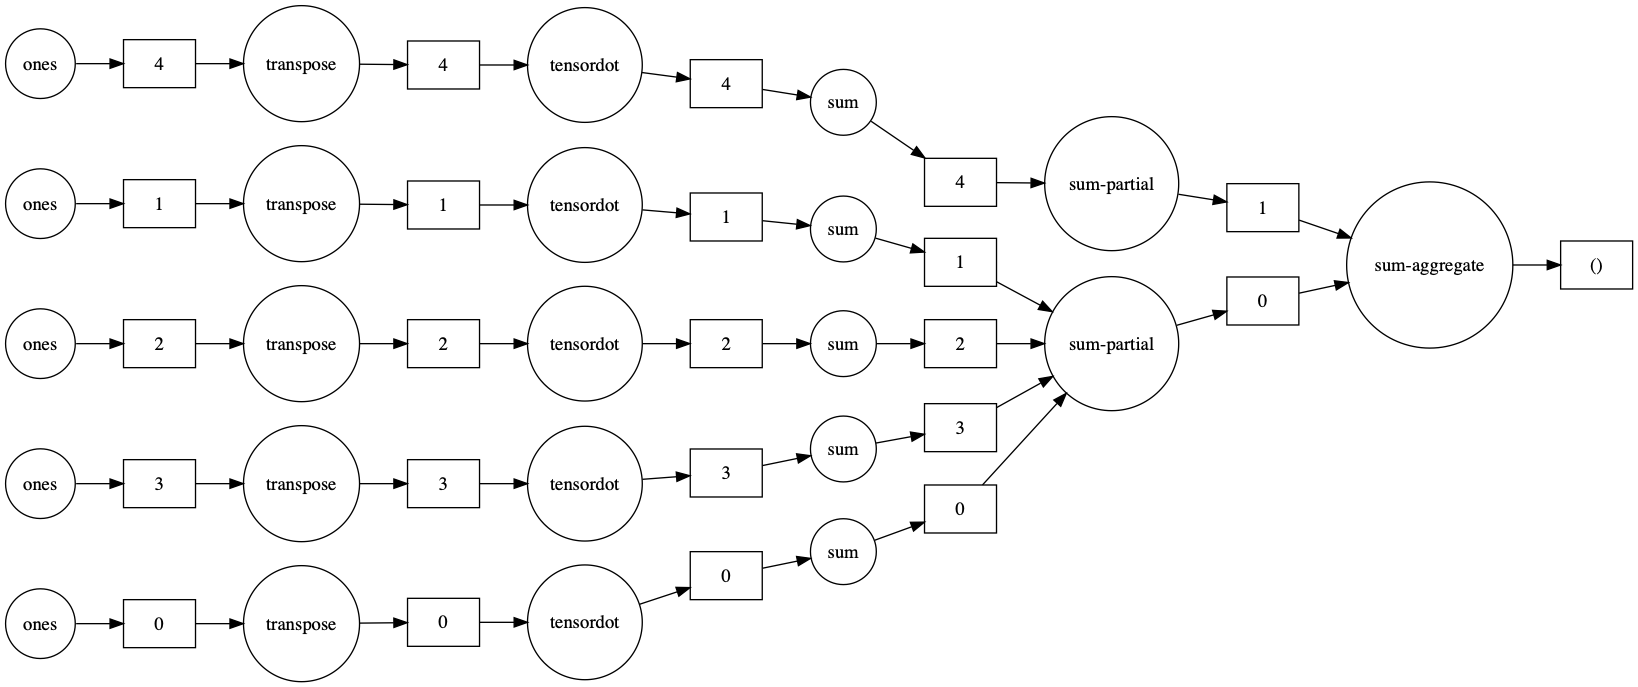

In [51]:
da.dot(arr_1.T, arr_2.T).visualize(rankdir="LR")

### 3.1 Creating Customer Task Graphs
We can also create our own custom task graphs. This is done to fully utilize out of core computation if current collections/functions are not suitable to our current applications. Let's see how this could be done:

In [55]:
def do_something_1(x, y):
    return x + y + 2*x*y


def do_something_2(a, b):
    return a**3 - b**3


def do_something_3(p, q):
    return p*p + q*q


def do_something_4(x):
    return x * 3

In [63]:
dsk = {
    "thrice_1": (do_something_4, 10),
    "thrice_2": (do_something_4, 20),
    "thrice_3": (do_something_4, 30),
    "thrice_4": (do_something_4, 40),
    "square_sum": (do_something_3, "thrice_1", "thrice_2"),
    "a_plus_b_wholeSquare": (do_something_1, "square_sum", "thrice_3"), 
    "some_complex_stuff": (do_something_2, "thrice_4", "a_plus_b_wholeSquare")
}

In [64]:
from dask.multiprocessing import get
my_task = get(dsk, "some_complex_stuff")

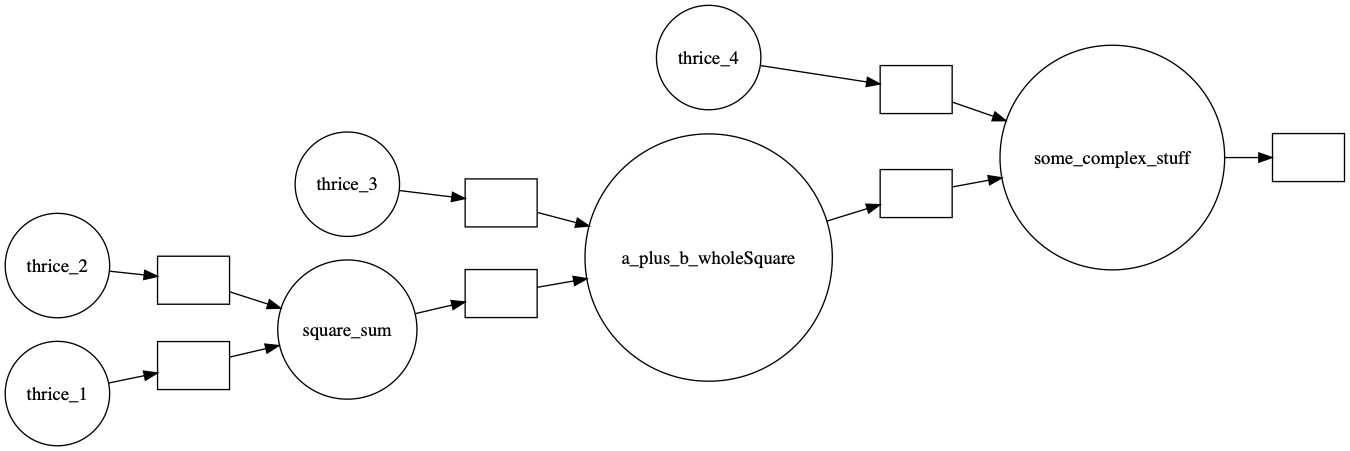

In [65]:
import dask
dask.visualize(dsk, rankdir="LR")

# 4. Performance Analysis with `dask.delayed` 
In order to determine basic performance analysis of dask delayed compared to native python, I will use the `sleep` function to mimic some complex calculation that is taking place.

In [80]:
from time import sleep

In [81]:
def do_something_1(x, y):
    sleep(1)
    return x + y + 2*x*y


def do_something_2(a, b):
    sleep(1)
    return a**3 - b**3


def do_something_3(p, q):
    sleep(1)
    return p*p + q*q

In [82]:
len_arr = 5

x = [i*2 for i in range(1, len_arr + 1)]
y = [i*3 for i in range(1, len_arr + 1)]
z = [i*10 for i in range(1, len_arr + 1)]

final_result = []

In [83]:
%%time 

for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)
    
sum_arr = sum(final_result)

CPU times: user 17 ms, sys: 4.31 ms, total: 21.3 ms
Wall time: 15 s


We can see that the total time taken was 15 seconds. We can use dask delayed to speed up this operation!

In [84]:
from dask import delayed, compute

In [85]:
@delayed
def do_something_1(x, y):
    sleep(1)
    return x + y + 2*x*y


@delayed
def do_something_2(a, b):
    sleep(1)
    return a**3 - b**3


@delayed
def do_something_3(p, q):
    sleep(1)
    return p*p + q*q

In [86]:
final_result = []
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)
    
final_sum = sum(final_result)

In [87]:
%%time
final_sum.compute()

CPU times: user 8.89 ms, sys: 3.59 ms, total: 12.5 ms
Wall time: 3.01 s


19422314786

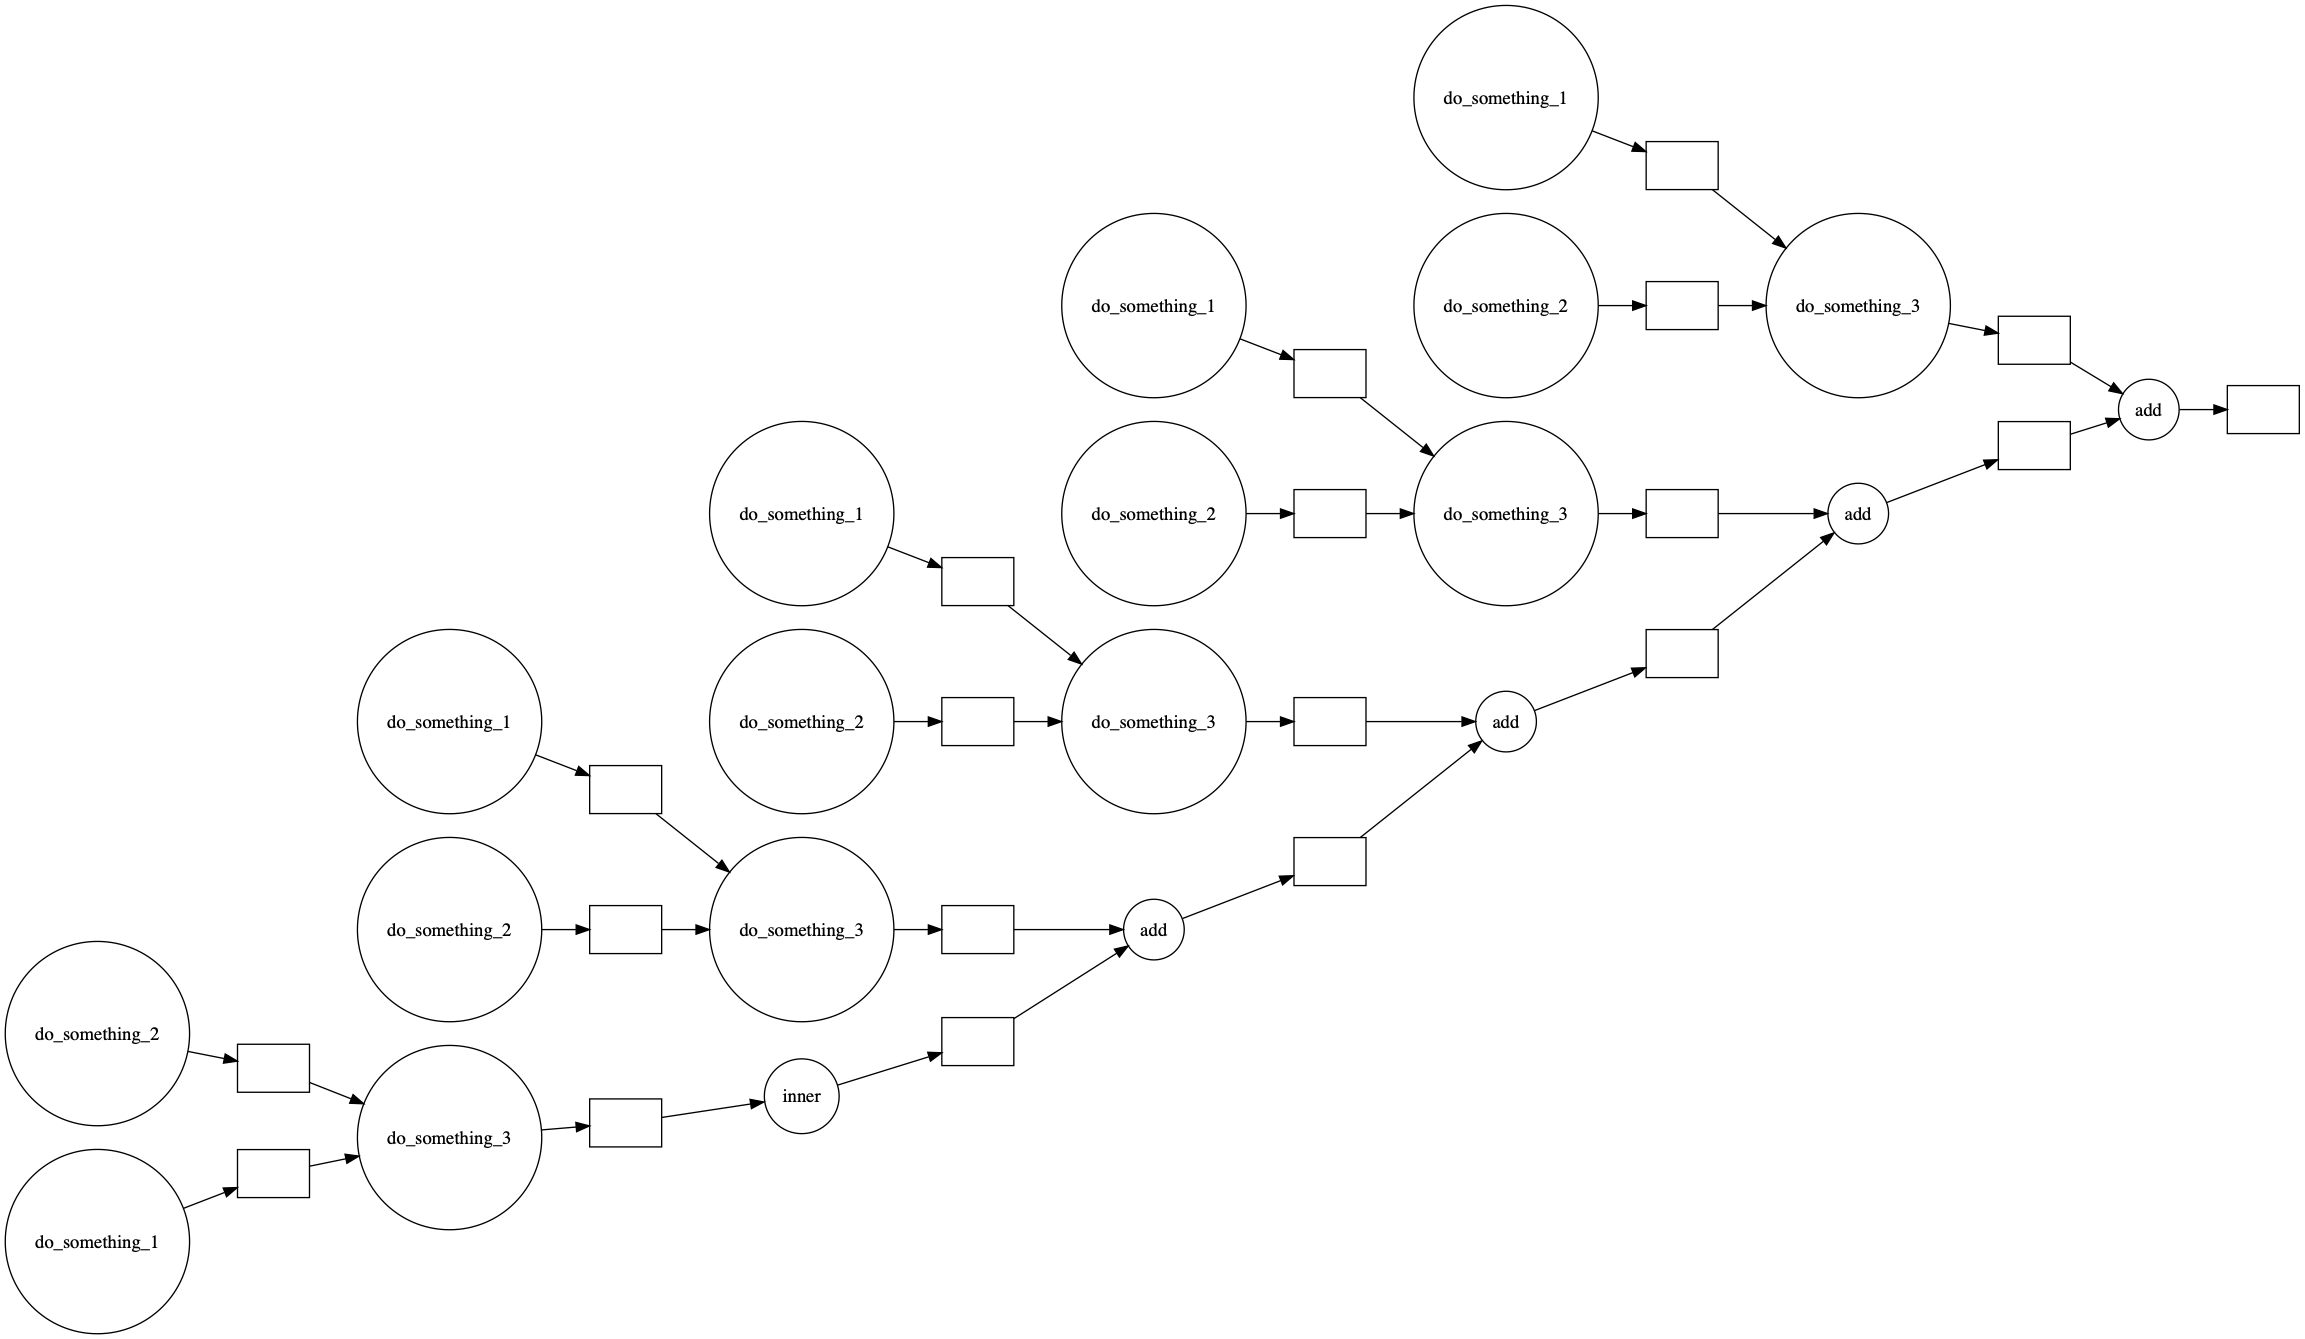

In [88]:
final_sum.visualize(rankdir="LR")

We achieve a nice performance boost here because when our code is executing in native python the `sleep`s occur serially. However, `dask.delayed` allows the sleeps to occur in parallel to one another. 

In [89]:
final_result = []
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)
    
final_sum = delayed(sum)(final_result)

In [90]:
%%time 
final_sum.compute()

CPU times: user 7.84 ms, sys: 3.63 ms, total: 11.5 ms
Wall time: 3.01 s


19422314786